# **Ujian Tengah Semester - Pengolahan Bahasa Alami**

## Anggota Kelompok
- **Kevin Philips Tanamas** (220711789)  
- **Richard Angelico** (220711747)
- **Anthony Alvin Nathaniel** (220711773)
- **Nicholas Raymond Thosimaru** (220712111)

Data Loading dan Import Library

In [1]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import plotly.graph_objects as go
import plotly.express as px
import missingno as msno

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from skmultilearn.problem_transform import BinaryRelevance, ClassifierChain
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, multilabel_confusion_matrix

In [2]:
train_data = pd.read_csv('./dataset_betawi/train_preprocess.csv', sep=';')
val_data = pd.read_csv('./dataset_betawi/valid_preprocess.csv', sep=';')
test_data = pd.read_csv('./dataset_betawi/test_preprocess.csv', sep=';')

print('Train Data: ', train_data.shape)
print('Validation Data: ', val_data.shape)
print('Test Data: ', test_data.shape)

print(train_data.describe(include='object'))
print(val_data.describe(include='object'))
print(test_data.describe(include='object'))

Train Data:  (810, 7)
Validation Data:  (90, 7)
Test Data:  (180, 7)
                               sentence     fuel  machine   others     part  \
count                               810      810      810      810      810   
unique                              809        3        3        3        3   
top     Jazz lebih bandel daripada Brio  neutral  neutral  neutral  neutral   
freq                                  2      679      635      531      576   

          price  service  
count       810      810  
unique        3        3  
top     neutral  neutral  
freq        674      690  
                                                 sentence     fuel  machine  \
count                                                  90       90       90   
unique                                                 90        3        3   
top     Honda Beat bikin semangat buat perjalanan jauh...  neutral  neutral   
freq                                                    1       77       72   

    

In [3]:
train_data.head(5)

,sentence,fuel,machine,others,part,price,service
0,Ane pake Honda Jazz GK5 2014 (pertama diluncur...,neutral,neutral,positive,neutral,neutral,neutral
1,Kenapa sih Avanza jadi boros bensin gini? Baru...,negative,neutral,neutral,neutral,neutral,neutral
2,"Saran gue dan pengalaman gue, lebih baik beli ...",positive,positive,neutral,neutral,neutral,neutral
3,"Dari segi harga, Pajero juga 30 juta lebih mah...",neutral,neutral,neutral,neutral,positive,neutral
4,"Menurut gue, Pajero itu enak",neutral,neutral,positive,neutral,neutral,neutral


In [4]:
val_data.head(5)

,sentence,fuel,machine,others,part,price,service
0,Honda Beat bikin semangat buat perjalanan jauh...,positive,positive,neutral,positive,neutral,neutral
1,Respon mesin Ertiga terlalu lambat.,neutral,negative,neutral,neutral,neutral,neutral
2,Pikiran lebih suka li. dapet penghematan supernya,positive,neutral,neutral,neutral,neutral,neutral
3,Gue juga punya HRV E 2018. Overall gue suka ny...,neutral,neutral,positive,neutral,neutral,neutral
4,"Jangan kayak gitu bro, menurut gue Karimun Wag...",neutral,neutral,positive,neutral,positive,neutral


In [5]:
test_data.head(5)

,sentence,fuel,machine,others,part,price,service
0,Terios paling jagoan! Apalagi yang warna merah...,neutral,neutral,positive,positive,neutral,neutral
1,Ane pake Mobilio. Menurut ane nyetirnya asik b...,neutral,neutral,positive,neutral,neutral,neutral
2,"Ya walaupun modelnya sporty, tapi kalo kenyama...",neutral,neutral,negative,positive,neutral,neutral
3,Xpander laris bener di pasar Indonesia!,neutral,neutral,positive,neutral,neutral,neutral
4,"Kalo mau serba enak, pake Avanza aje, bang.",neutral,neutral,positive,neutral,neutral,neutral


Data Visualization

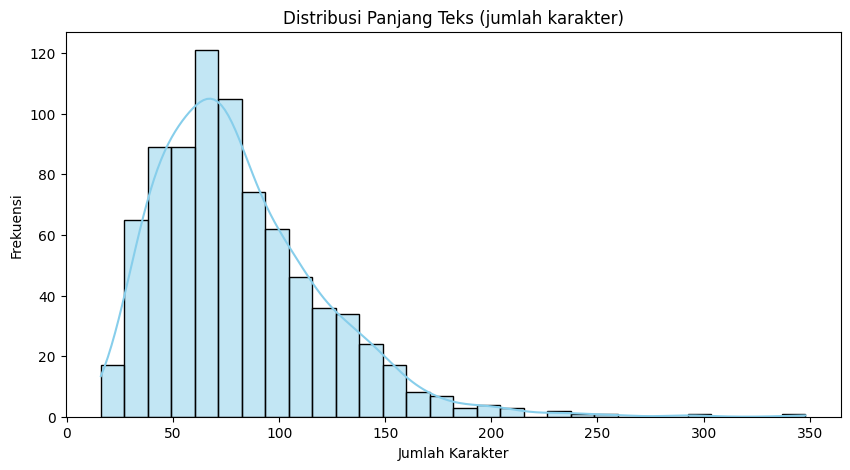

In [6]:
# Distribusi Jumlah Karakter dalam Kalimat
train_data['text_length'] = train_data['sentence'].apply(len)

plt.figure(figsize=(10, 5))
sns.histplot(train_data['text_length'], bins=30, kde=True, color='skyblue')
plt.title('Distribusi Panjang Teks (jumlah karakter)')
plt.xlabel('Jumlah Karakter')
plt.ylabel('Frekuensi')
plt.show()

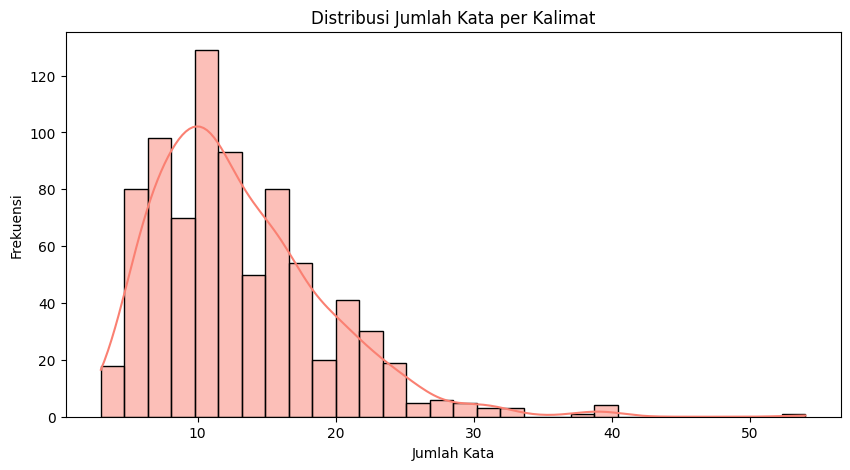

In [7]:
# Distribusi Jumlah Kata per Kalimat
train_data['word_count'] = train_data['sentence'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10, 5))
sns.histplot(train_data['word_count'], bins=30, kde=True, color='salmon')
plt.title('Distribusi Jumlah Kata per Kalimat')
plt.xlabel('Jumlah Kata')
plt.ylabel('Frekuensi')
plt.show()

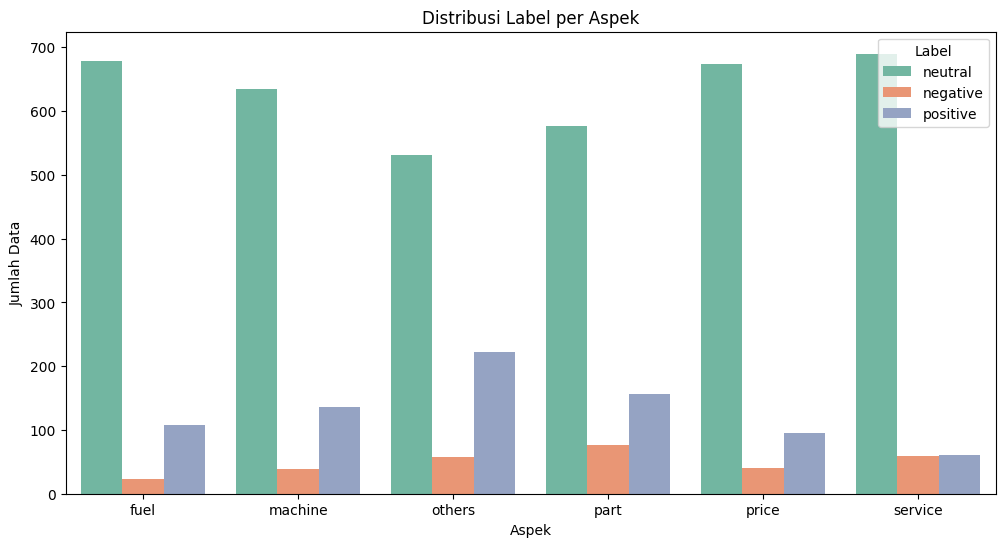

In [8]:
# Distribusi Label per Aspek
label_columns = ['fuel', 'machine', 'others', 'part', 'price', 'service']

melted_train = train_data.melt(id_vars='sentence', value_vars=label_columns,
                                var_name='aspek', value_name='label')

plt.figure(figsize=(12, 6))
sns.countplot(data=melted_train, x='aspek', hue='label', palette='Set2')
plt.title('Distribusi Label per Aspek')
plt.xlabel('Aspek')
plt.ylabel('Jumlah Data')
plt.legend(title='Label')
plt.show()

C:\Users\Pongo\AppData\Local\Temp\ipykernel_21788\1532230726.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  encoded_labels = train_data[label_columns].replace({'positive': 1, 'neutral': 0, 'negative': -1})


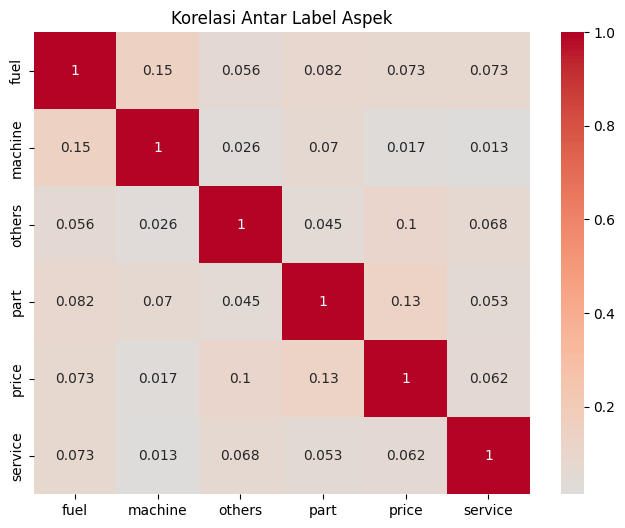

In [9]:
# Corelation Matrix
encoded_labels = train_data[label_columns].replace({'positive': 1, 'neutral': 0, 'negative': -1})

plt.figure(figsize=(8, 6))
sns.heatmap(encoded_labels.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Korelasi Antar Label Aspek')
plt.show()

Data Preprocessing

In [10]:
# Text Processing / Cleaning Data
def clean_text(text):
    text = text.lower()  # lowercase
    text = re.sub(r'\d+', '', text)  # hapus angka
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)  # hapus tanda baca
    text = re.sub(r'\s+', ' ', text)  # hapus spasi berlebih
    text = text.strip()  # hapus spasi di awal dan akhir
    return text

train_data['clean_text'] = train_data['sentence'].apply(clean_text)
val_data['clean_text'] = val_data['sentence'].apply(clean_text)
test_data['clean_text'] = test_data['sentence'].apply(clean_text)

In [11]:
# One-Hot Encoding
labels = ['fuel', 'machine', 'others', 'part', 'price', 'service']

train_encoded = pd.get_dummies(train_data, columns=labels, dtype=int)
val_encoded = pd.get_dummies(val_data, columns=labels, dtype=int)
test_encoded = pd.get_dummies(test_data, columns=labels, dtype=int)

In [12]:
train_encoded.head(10)

,sentence,text_length,word_count,clean_text,fuel_negative,fuel_neutral,fuel_positive,machine_negative,machine_neutral,machine_positive,...,others_positive,part_negative,part_neutral,part_positive,price_negative,price_neutral,price_positive,service_negative,service_neutral,service_positive
0,Ane pake Honda Jazz GK5 2014 (pertama diluncur...,113,18,ane pake honda jazz gk pertama diluncurkan mob...,0,1,0,0,1,0,...,1,0,1,0,0,1,0,0,1,0
1,Kenapa sih Avanza jadi boros bensin gini? Baru...,68,11,kenapa sih avanza jadi boros bensin gini baru ...,1,0,0,0,1,0,...,0,0,1,0,0,1,0,0,1,0
2,"Saran gue dan pengalaman gue, lebih baik beli ...",103,17,saran gue dan pengalaman gue lebih baik beli m...,0,0,1,0,0,1,...,0,0,1,0,0,1,0,0,1,0
3,"Dari segi harga, Pajero juga 30 juta lebih mah...",62,11,dari segi harga pajero juga juta lebih mahal d...,0,1,0,0,1,0,...,0,0,1,0,0,0,1,0,1,0
4,"Menurut gue, Pajero itu enak",28,5,menurut gue pajero itu enak,0,1,0,0,1,0,...,1,0,1,0,0,1,0,0,1,0
5,Versi CH-R negara ini kagak pantes dari segi f...,66,11,versi chr negara ini kagak pantes dari segi fi...,0,1,0,0,1,0,...,0,1,0,0,0,1,0,0,1,0
6,LinaRadj cobain tukang tambal Daihatsu kapan-k...,99,13,linaradj cobain tukang tambal daihatsu kapanka...,0,1,0,0,1,0,...,0,0,1,0,0,1,0,0,0,1
7,Mending kalo confero lebih murah dari formo.,44,7,mending kalo confero lebih murah dari formo,0,1,0,0,1,0,...,0,0,1,0,1,0,0,0,1,0
8,"Kalo soal service, lebih baik pilih Grand Livi...",95,15,kalo soal service lebih baik pilih grand livin...,0,1,0,0,1,0,...,0,0,1,0,0,1,0,0,0,1
9,Lampu depan Grand New Veloz juga dapet perubah...,103,16,lampu depan grand new veloz juga dapet perubah...,0,1,0,0,1,0,...,0,0,0,1,0,1,0,0,1,0


In [13]:
test_encoded.head(10)

,sentence,clean_text,fuel_negative,fuel_neutral,fuel_positive,machine_negative,machine_neutral,machine_positive,others_negative,others_neutral,others_positive,part_negative,part_neutral,part_positive,price_negative,price_neutral,price_positive,service_negative,service_neutral,service_positive
0,Terios paling jagoan! Apalagi yang warna merah...,terios paling jagoan apalagi yang warna merah ...,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,0
1,Ane pake Mobilio. Menurut ane nyetirnya asik b...,ane pake mobilio menurut ane nyetirnya asik ba...,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0
2,"Ya walaupun modelnya sporty, tapi kalo kenyama...",ya walaupun modelnya sporty tapi kalo kenyaman...,0,1,0,0,1,0,1,0,0,0,0,1,0,1,0,0,1,0
3,Xpander laris bener di pasar Indonesia!,xpander laris bener di pasar indonesia,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0
4,"Kalo mau serba enak, pake Avanza aje, bang.",kalo mau serba enak pake avanza aje bang,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0
5,"Kalo buat mahasiswa, mending pake Vario aje!",kalo buat mahasiswa mending pake vario aje,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0
6,Enak bener naik Toyota Rush!,enak bener naik toyota rush,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0
7,"Xpander enak bener dipakenye, pokoknya selalu ...",xpander enak bener dipakenye pokoknya selalu d...,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0
8,Gue sih udah nyaman banget pake Vario!,gue sih udah nyaman banget pake vario,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0
9,Scoopy bener-bener ngepas buat mobilitas gue t...,scoopy benerbener ngepas buat mobilitas gue ti...,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0


In [14]:
val_encoded.head(10)

,sentence,clean_text,fuel_negative,fuel_neutral,fuel_positive,machine_negative,machine_neutral,machine_positive,others_negative,others_neutral,others_positive,part_negative,part_neutral,part_positive,price_negative,price_neutral,price_positive,service_negative,service_neutral,service_positive
0,Honda Beat bikin semangat buat perjalanan jauh...,honda beat bikin semangat buat perjalanan jauh...,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0
1,Respon mesin Ertiga terlalu lambat.,respon mesin ertiga terlalu lambat,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0
2,Pikiran lebih suka li. dapet penghematan supernya,pikiran lebih suka li dapet penghematan supernya,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0
3,Gue juga punya HRV E 2018. Overall gue suka ny...,gue juga punya hrv e overall gue suka nyetirnya,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0
4,"Jangan kayak gitu bro, menurut gue Karimun Wag...",jangan kayak gitu bro menurut gue karimun wago...,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,1,0
5,Lebih harga honda brio RS,lebih harga honda brio rs,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0
6,"Memang bodinya kalah sama Pajero, tapi kalo so...",memang bodinya kalah sama pajero tapi kalo soa...,0,1,0,0,0,1,0,1,0,1,0,0,0,1,0,0,1,0
7,"Awalnya orang tua gue tertarik sama mobil ini,...",awalnya orang tua gue tertarik sama mobil ini ...,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0
8,"Memang sih, semua Xenia irit bahan bakar, tapi...",memang sih semua xenia irit bahan bakar tapi k...,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0
9,Bengkel Toyota Pemuda punya pelayanan yang ben...,bengkel toyota pemuda punya pelayanan yang ben...,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1


Feature Engineering

In [15]:
# Mendefinisikan Label untuk Multi-label Classification
label_columns = [
    'fuel_negative', 'fuel_neutral', 'fuel_positive',
    'machine_negative', 'machine_neutral', 'machine_positive'
]

y_train_multi = train_encoded[label_columns]
y_val_multi = val_encoded[label_columns]
y_test_multi = test_encoded[label_columns]

In [16]:
# TF-IDF Vectorizer
vectorizer = TfidfVectorizer()
X_train_tfvec = vectorizer.fit_transform(train_data['clean_text'])
X_val_tfvec = vectorizer.transform(val_data['clean_text'])
X_test_tfvec = vectorizer.transform(test_data['clean_text'])

In [17]:
# Implementasi Word2Vec
from gensim.models import Word2Vec
import numpy as np

sentences = [text.split() for text in train_data['clean_text']]

w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

def get_avg_w2v_vector(text, model):
    words = text.split()
    vectors = [model.wv[word] for word in words if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

X_train_w2v = np.vstack([get_avg_w2v_vector(text, w2v_model) for text in train_data['clean_text']])
X_val_w2v = np.vstack([get_avg_w2v_vector(text, w2v_model) for text in val_data['clean_text']])
X_test_w2v = np.vstack([get_avg_w2v_vector(text, w2v_model) for text in test_data['clean_text']])

In [18]:
# Bag of Words
bow_vectorizer = CountVectorizer()
X_train_bow = bow_vectorizer.fit_transform(train_data['clean_text'])
X_val_bow = bow_vectorizer.transform(val_data['clean_text'])
X_test_bow = bow_vectorizer.transform(test_data['clean_text'])

# Bag of N-grams
ngram_vectorizer = CountVectorizer(ngram_range=(1, 2))
X_train_ngram = ngram_vectorizer.fit_transform(train_data['clean_text'])
X_val_ngram = ngram_vectorizer.transform(val_data['clean_text'])
X_test_ngram = ngram_vectorizer.transform(test_data['clean_text'])

Model Training


Running SVM with BinaryRelevance...
Best Parameters for SVM: {'classifier__C': 10, 'classifier__kernel': 'linear'}
SVM Cross-Validation Accuracy: 0.7630

Running SVM with ClassifierChain...
Best Parameters for SVM: {'classifier__C': 10, 'classifier__kernel': 'linear'}
SVM Cross-Validation Accuracy: 0.8012

Running KNN with BinaryRelevance...
Best Parameters for KNN: {'classifier__n_neighbors': 5, 'classifier__weights': 'uniform'}
KNN Cross-Validation Accuracy: 0.7136

Running KNN with ClassifierChain...
Best Parameters for KNN: {'classifier__n_neighbors': 7, 'classifier__weights': 'distance'}
KNN Cross-Validation Accuracy: 0.7309

Running NB with BinaryRelevance...
Best Parameters for NB: {'classifier__alpha': 0.1, 'classifier__fit_prior': True}
NB Cross-Validation Accuracy: 0.6802

Running NB with ClassifierChain...
Best Parameters for NB: {'classifier__alpha': 0.1, 'classifier__fit_prior': True}
NB Cross-Validation Accuracy: 0.7210
  Model        Transform                           

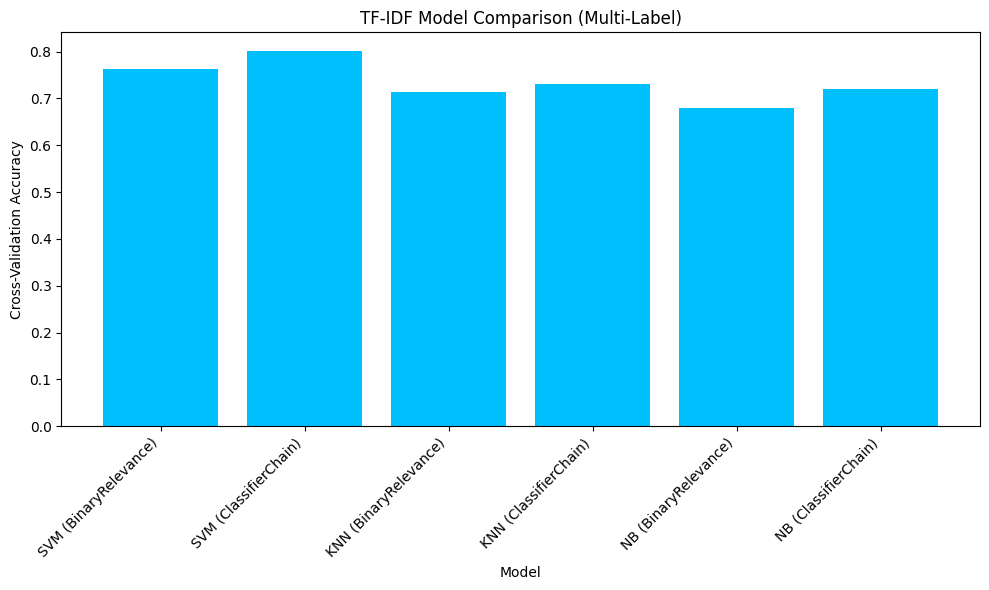

In [19]:
# TF-IDF

param_grids_multi = {
    'SVM': {
        'classifier__kernel': ['linear', 'rbf'],
        'classifier__C': [0.1, 1, 10]
    },
    'KNN': {
        'classifier__n_neighbors': [3, 5, 7],
        'classifier__weights': ['uniform', 'distance']
    },
    'NB': {
        'classifier__alpha': [0.1, 0.5, 1.0],
        'classifier__fit_prior': [True, False]
    }
}

base_models = {
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier(),
    "NB": MultinomialNB()
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)
best_multi_models = {}
results_multi_tfvec = []
metrics_data = []

for model_name, base_model in base_models.items():
    for problem_transform in [BinaryRelevance, ClassifierChain]:
        print(f"\nRunning {model_name} with {problem_transform.__name__}...")
        
        br_model =  problem_transform(classifier=base_model)
    
        grid = GridSearchCV(
            br_model,
            param_grids_multi[model_name],
            cv=kf,
            scoring='accuracy',
            n_jobs=-1
        )

        grid.fit(X_train_tfvec, y_train_multi)

        key_name = f"{model_name}_{problem_transform.__name__}"
        best_multi_models[model_name] = grid.best_estimator_

        results_multi_tfvec.append((model_name, problem_transform.__name__, grid.best_score_))
        metrics_data.append({
            'Model': model_name,
            'Transform': problem_transform.__name__,
            'Best Parameters': grid.best_params_,
            'Cross-Validation Accuracy': grid.best_score_
        })
        
        print(f"Best Parameters for {model_name}: {grid.best_params_}")
        print(f"{model_name} Cross-Validation Accuracy: {grid.best_score_:.4f}")

metrics_df_tfvec = pd.DataFrame(metrics_data)
print(metrics_df_tfvec)

plt.figure(figsize=(10, 6))
plt.bar(
    [f"{model[0]} ({model[1]})" for model in results_multi_tfvec],
    [model[2] for model in results_multi_tfvec],
    color='deepskyblue'
)
plt.xlabel('Model')
plt.ylabel('Cross-Validation Accuracy')
plt.title('TF-IDF Model Comparison (Multi-Label)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Running SVM with BinaryRelevance...
Best Parameters for SVM: {'classifier__C': 0.1, 'classifier__kernel': 'linear'}
SVM Cross-Validation Accuracy: 0.6654

Running SVM with ClassifierChain...
Best Parameters for SVM: {'classifier__C': 0.1, 'classifier__kernel': 'linear'}
SVM Cross-Validation Accuracy: 0.6654

Running KNN with BinaryRelevance...
Best Parameters for KNN: {'classifier__n_neighbors': 7, 'classifier__weights': 'distance'}
KNN Cross-Validation Accuracy: 0.6198

Running KNN with ClassifierChain...
Best Parameters for KNN: {'classifier__n_neighbors': 7, 'classifier__weights': 'distance'}
KNN Cross-Validation Accuracy: 0.6457
  Model        Transform                                    Best Parameters  \
0   SVM  BinaryRelevance  {'classifier__C': 0.1, 'classifier__kernel': '...   
1   SVM  ClassifierChain  {'classifier__C': 0.1, 'classifier__kernel': '...   
2   KNN  BinaryRelevance  {'classifier__n_neighbors': 7, 'classifier__we...   
3   KNN  ClassifierChain  {'classifier__n_

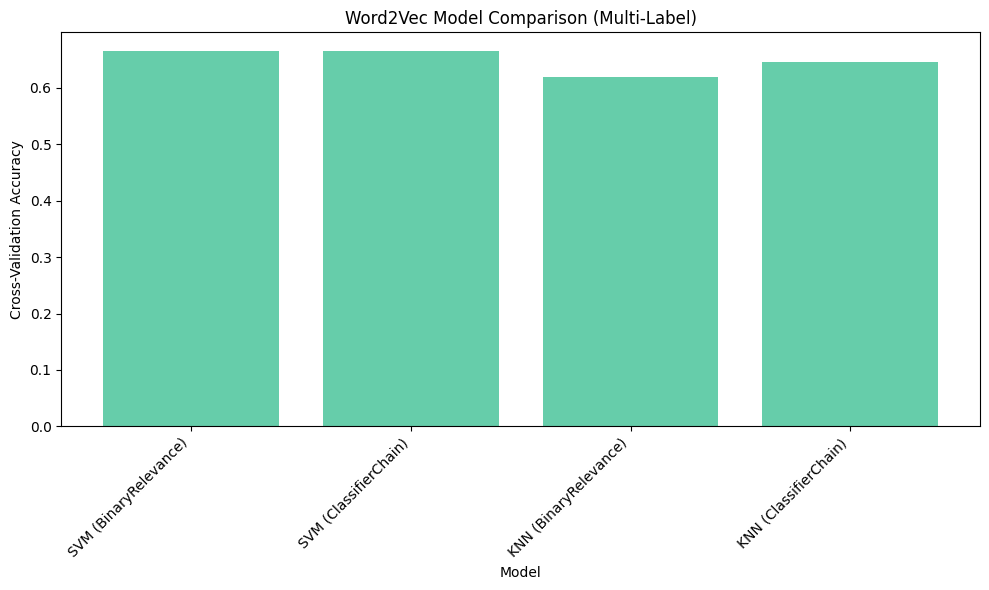

In [20]:
# Word2Vec

param_grids_multi = {
    'SVM': {
        'classifier__kernel': ['linear', 'rbf'],
        'classifier__C': [0.1, 1, 10]
    },
    'KNN': {
        'classifier__n_neighbors': [3, 5, 7],
        'classifier__weights': ['uniform', 'distance']
    }
}

base_models = {
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier()
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)
best_multi_models = {}
results_multi_w2v = []
metrics_data = []

for model_name, base_model in base_models.items():
    for problem_transform in [BinaryRelevance, ClassifierChain]:
        print(f"\nRunning {model_name} with {problem_transform.__name__}...")
        
        br_model =  problem_transform(classifier=base_model)
    
        grid = GridSearchCV(
            br_model,
            param_grids_multi[model_name],
            cv=kf,
            scoring='accuracy',
            n_jobs=-1
        )

        grid.fit(X_train_w2v, y_train_multi)

        key_name = f"{model_name}_{problem_transform.__name__}"
        best_multi_models[model_name] = grid.best_estimator_

        results_multi_w2v.append((model_name, problem_transform.__name__, grid.best_score_))
        metrics_data.append({
            'Model': model_name,
            'Transform': problem_transform.__name__,
            'Best Parameters': grid.best_params_,
            'Cross-Validation Accuracy': grid.best_score_
        })
        
        print(f"Best Parameters for {model_name}: {grid.best_params_}")
        print(f"{model_name} Cross-Validation Accuracy: {grid.best_score_:.4f}")

metrics_df_w2v = pd.DataFrame(metrics_data)
print(metrics_df_w2v)

plt.figure(figsize=(10, 6))
plt.bar(
    [f"{model[0]} ({model[1]})" for model in results_multi_w2v],
    [model[2] for model in results_multi_w2v],
    color='mediumaquamarine'
)
plt.xlabel('Model')
plt.ylabel('Cross-Validation Accuracy')
plt.title('Word2Vec Model Comparison (Multi-Label)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Running SVM with BinaryRelevance...
Best Parameters for SVM: {'classifier__C': 0.1, 'classifier__kernel': 'linear'}
SVM Cross-Validation Accuracy: 0.7852

Running SVM with ClassifierChain...
Best Parameters for SVM: {'classifier__C': 0.1, 'classifier__kernel': 'linear'}
SVM Cross-Validation Accuracy: 0.8074

Running KNN with BinaryRelevance...
Best Parameters for KNN: {'classifier__n_neighbors': 5, 'classifier__weights': 'uniform'}
KNN Cross-Validation Accuracy: 0.6951

Running KNN with ClassifierChain...
Best Parameters for KNN: {'classifier__n_neighbors': 5, 'classifier__weights': 'uniform'}
KNN Cross-Validation Accuracy: 0.7074

Running NB with BinaryRelevance...
Best Parameters for NB: {'classifier__alpha': 1.0, 'classifier__fit_prior': True}
NB Cross-Validation Accuracy: 0.6827

Running NB with ClassifierChain...
Best Parameters for NB: {'classifier__alpha': 1.0, 'classifier__fit_prior': True}
NB Cross-Validation Accuracy: 0.7198
  Model        Transform                          

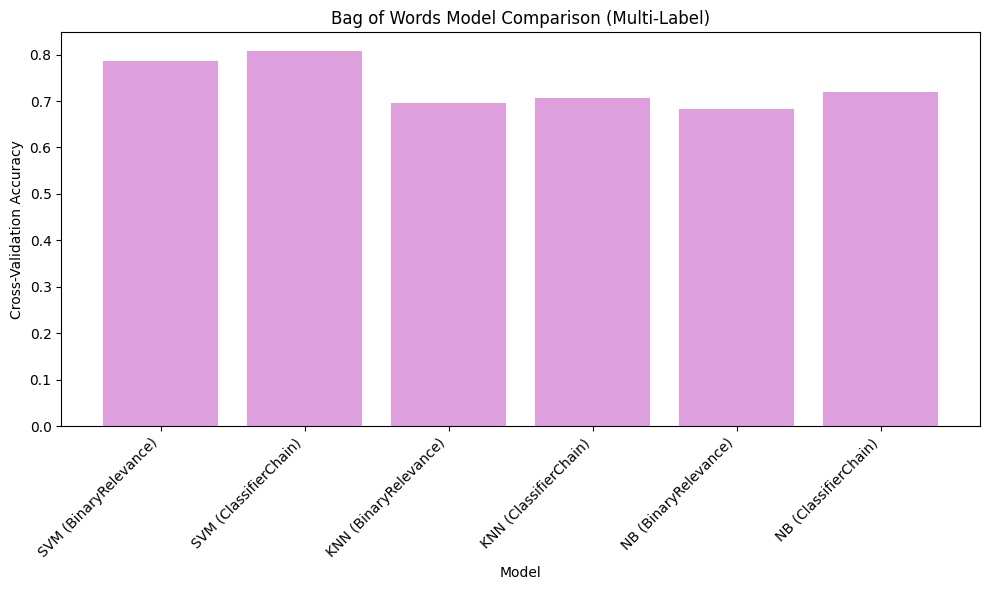

In [21]:
# Bag of Words

param_grids_multi = {
    'SVM': {
        'classifier__kernel': ['linear', 'rbf'],
        'classifier__C': [0.1, 1, 10]
    },
    'KNN': {
        'classifier__n_neighbors': [3, 5, 7],
        'classifier__weights': ['uniform', 'distance']
    },
    'NB': {
        'classifier__alpha': [0.1, 0.5, 1.0],
        'classifier__fit_prior': [True, False]
    }
}

base_models = {
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier(),
    "NB": MultinomialNB()
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)
best_multi_models = {}
results_multi_bow = []
metrics_data = []

for model_name, base_model in base_models.items():
    for problem_transform in [BinaryRelevance, ClassifierChain]:
        print(f"\nRunning {model_name} with {problem_transform.__name__}...")
        
        br_model =  problem_transform(classifier=base_model)
    
        grid = GridSearchCV(
            br_model,
            param_grids_multi[model_name],
            cv=kf,
            scoring='accuracy',
            n_jobs=-1
        )

        grid.fit(X_train_bow, y_train_multi)

        key_name = f"{model_name}_{problem_transform.__name__}"
        best_multi_models[model_name] = grid.best_estimator_

        results_multi_bow.append((model_name, problem_transform.__name__, grid.best_score_))
        metrics_data.append({
            'Model': model_name,
            'Transform': problem_transform.__name__,
            'Best Parameters': grid.best_params_,
            'Cross-Validation Accuracy': grid.best_score_
        })
        
        print(f"Best Parameters for {model_name}: {grid.best_params_}")
        print(f"{model_name} Cross-Validation Accuracy: {grid.best_score_:.4f}")

metrics_df_bow = pd.DataFrame(metrics_data)
print(metrics_df_bow)

plt.figure(figsize=(10, 6))
plt.bar(
    [f"{model[0]} ({model[1]})" for model in results_multi_bow],
    [model[2] for model in results_multi_bow],
    color='plum'
)
plt.xlabel('Model')
plt.ylabel('Cross-Validation Accuracy')
plt.title('Bag of Words Model Comparison (Multi-Label)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Running SVM with BinaryRelevance...
Best Parameters for SVM: {'classifier__C': 1, 'classifier__kernel': 'linear'}
SVM Cross-Validation Accuracy: 0.7852

Running SVM with ClassifierChain...
Best Parameters for SVM: {'classifier__C': 1, 'classifier__kernel': 'linear'}
SVM Cross-Validation Accuracy: 0.8099

Running KNN with BinaryRelevance...
Best Parameters for KNN: {'classifier__n_neighbors': 3, 'classifier__weights': 'uniform'}
KNN Cross-Validation Accuracy: 0.6951

Running KNN with ClassifierChain...
Best Parameters for KNN: {'classifier__n_neighbors': 5, 'classifier__weights': 'distance'}
KNN Cross-Validation Accuracy: 0.6975

Running NB with BinaryRelevance...
Best Parameters for NB: {'classifier__alpha': 1.0, 'classifier__fit_prior': True}
NB Cross-Validation Accuracy: 0.6284

Running NB with ClassifierChain...
Best Parameters for NB: {'classifier__alpha': 1.0, 'classifier__fit_prior': True}
NB Cross-Validation Accuracy: 0.6605
  Model        Transform                             

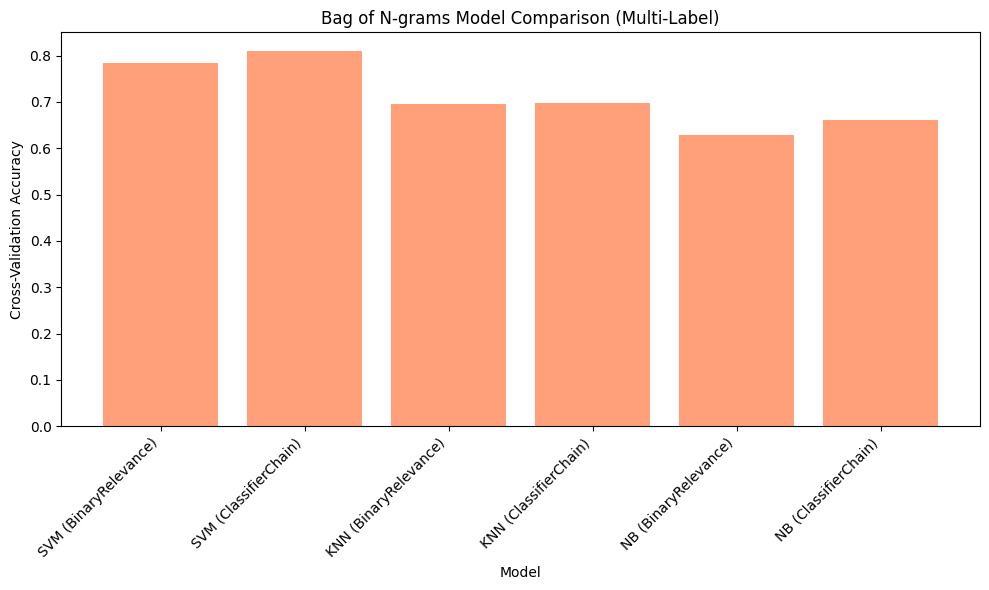

In [22]:
# Bag of N-grams

param_grids_multi = {
    'SVM': {
        'classifier__kernel': ['linear', 'rbf'],
        'classifier__C': [0.1, 1, 10]
    },
    'KNN': {
        'classifier__n_neighbors': [3, 5, 7],
        'classifier__weights': ['uniform', 'distance']
    },
    'NB': {
        'classifier__alpha': [0.1, 0.5, 1.0],
        'classifier__fit_prior': [True, False]
    }
}

base_models = {
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier(),
    "NB": MultinomialNB()
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)
best_multi_models = {}
results_multi_ngram = []
metrics_data = []

for model_name, base_model in base_models.items():
    for problem_transform in [BinaryRelevance, ClassifierChain]:
        print(f"\nRunning {model_name} with {problem_transform.__name__}...")
        
        br_model =  problem_transform(classifier=base_model)
    
        grid = GridSearchCV(
            br_model,
            param_grids_multi[model_name],
            cv=kf,
            scoring='accuracy',
            n_jobs=-1
        )

        grid.fit(X_train_ngram, y_train_multi)

        key_name = f"{model_name}_{problem_transform.__name__}"
        best_multi_models[model_name] = grid.best_estimator_

        results_multi_ngram.append((model_name, problem_transform.__name__, grid.best_score_))
        metrics_data.append({
            'Model': model_name,
            'Transform': problem_transform.__name__,
            'Best Parameters': grid.best_params_,
            'Cross-Validation Accuracy': grid.best_score_
        })
        
        print(f"Best Parameters for {model_name}: {grid.best_params_}")
        print(f"{model_name} Cross-Validation Accuracy: {grid.best_score_:.4f}")

metrics_df_ngram = pd.DataFrame(metrics_data)
print(metrics_df_ngram)

plt.figure(figsize=(10, 6))
plt.bar(
    [f"{model[0]} ({model[1]})" for model in results_multi_ngram],
    [model[2] for model in results_multi_ngram],
    color='lightsalmon'
)
plt.xlabel('Model')
plt.ylabel('Cross-Validation Accuracy')
plt.title('Bag of N-grams Model Comparison (Multi-Label)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Model Evaluation


SVM Test Evaluation:
Final Accuracy: 0.7833
SVM Classification Report:
                  precision    recall  f1-score   support

   fuel_negative       1.00      0.80      0.89        10
    fuel_neutral       0.90      1.00      0.95       149
   fuel_positive       0.86      0.29      0.43        21
machine_negative       0.50      0.07      0.12        14
 machine_neutral       0.88      0.99      0.93       137
machine_positive       0.79      0.66      0.72        29

       micro avg       0.88      0.89      0.88       360
       macro avg       0.82      0.63      0.67       360
    weighted avg       0.87      0.89      0.86       360
     samples avg       0.88      0.89      0.89       360

SVM Confusion Matrix:


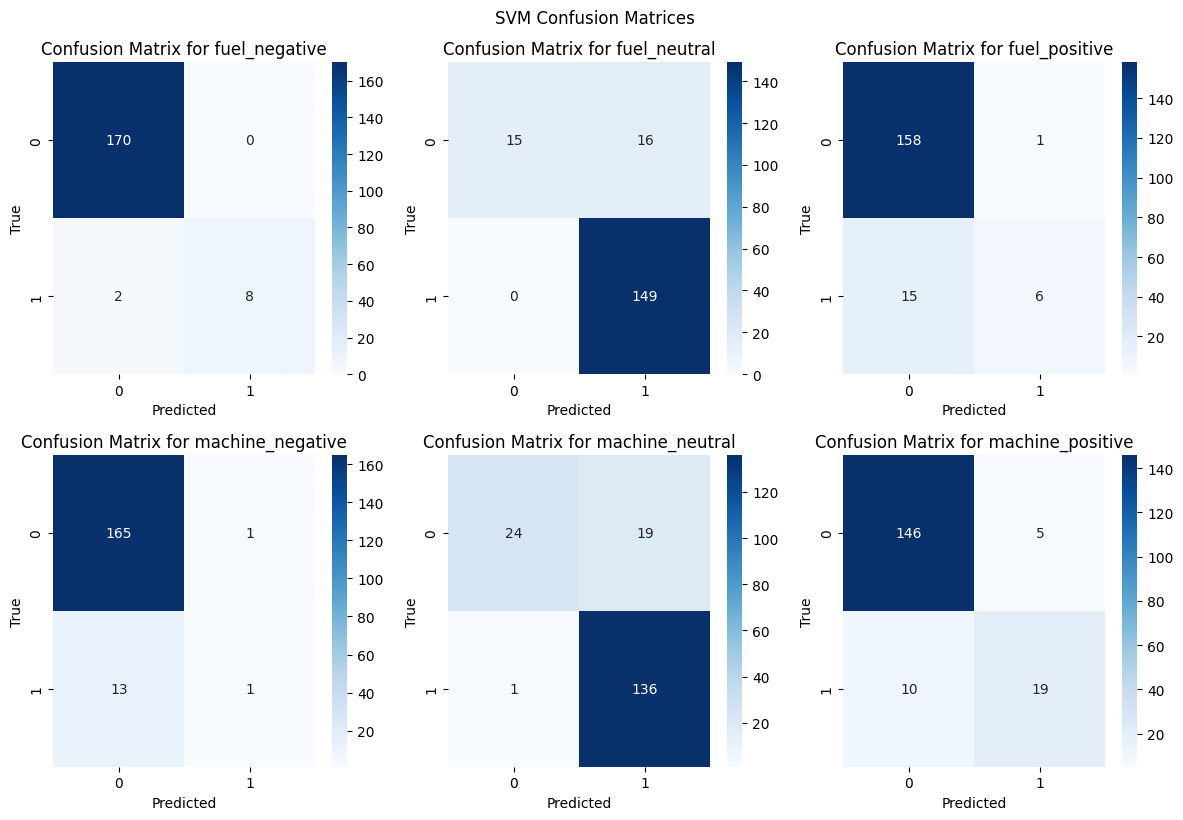


KNN Test Evaluation:
Final Accuracy: 0.6389
KNN Classification Report:
                  precision    recall  f1-score   support

   fuel_negative       1.00      0.00      0.00        10
    fuel_neutral       0.83      0.99      0.91       149
   fuel_positive       0.00      0.00      0.00        21
machine_negative       1.00      0.07      0.13        14
 machine_neutral       0.77      1.00      0.87       137
machine_positive       1.00      0.03      0.07        29

       micro avg       0.80      0.80      0.80       360
       macro avg       0.77      0.35      0.33       360
    weighted avg       0.78      0.80      0.72       360
     samples avg       0.80      0.80      0.80       360

KNN Confusion Matrix:


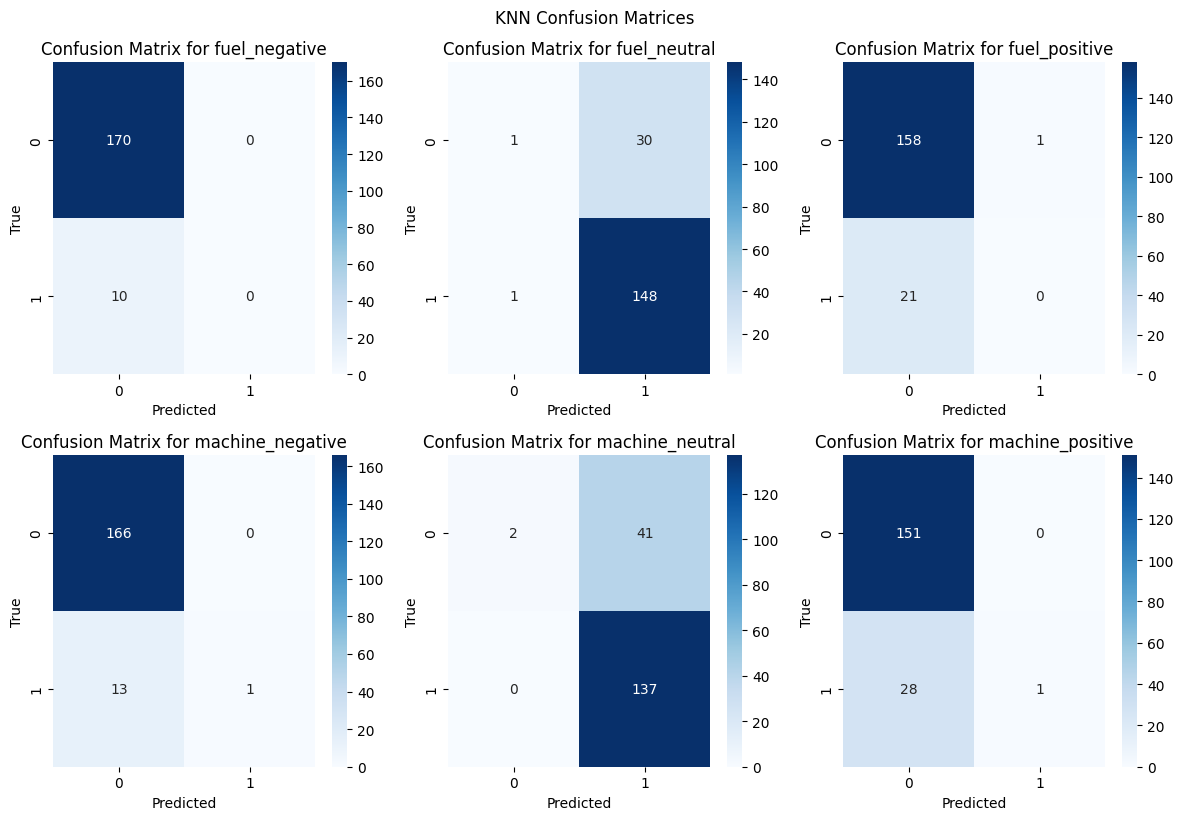


NB Test Evaluation:
Final Accuracy: 0.6889
NB Classification Report:
                  precision    recall  f1-score   support

   fuel_negative       1.00      0.00      0.00        10
    fuel_neutral       0.90      1.00      0.95       149
   fuel_positive       0.83      0.24      0.37        21
machine_negative       1.00      0.00      0.00        14
 machine_neutral       0.84      0.99      0.91       137
machine_positive       0.78      0.24      0.37        29

       micro avg       0.87      0.82      0.85       360
       macro avg       0.89      0.41      0.43       360
    weighted avg       0.87      0.82      0.79       360
     samples avg       0.88      0.82      0.84       360

NB Confusion Matrix:


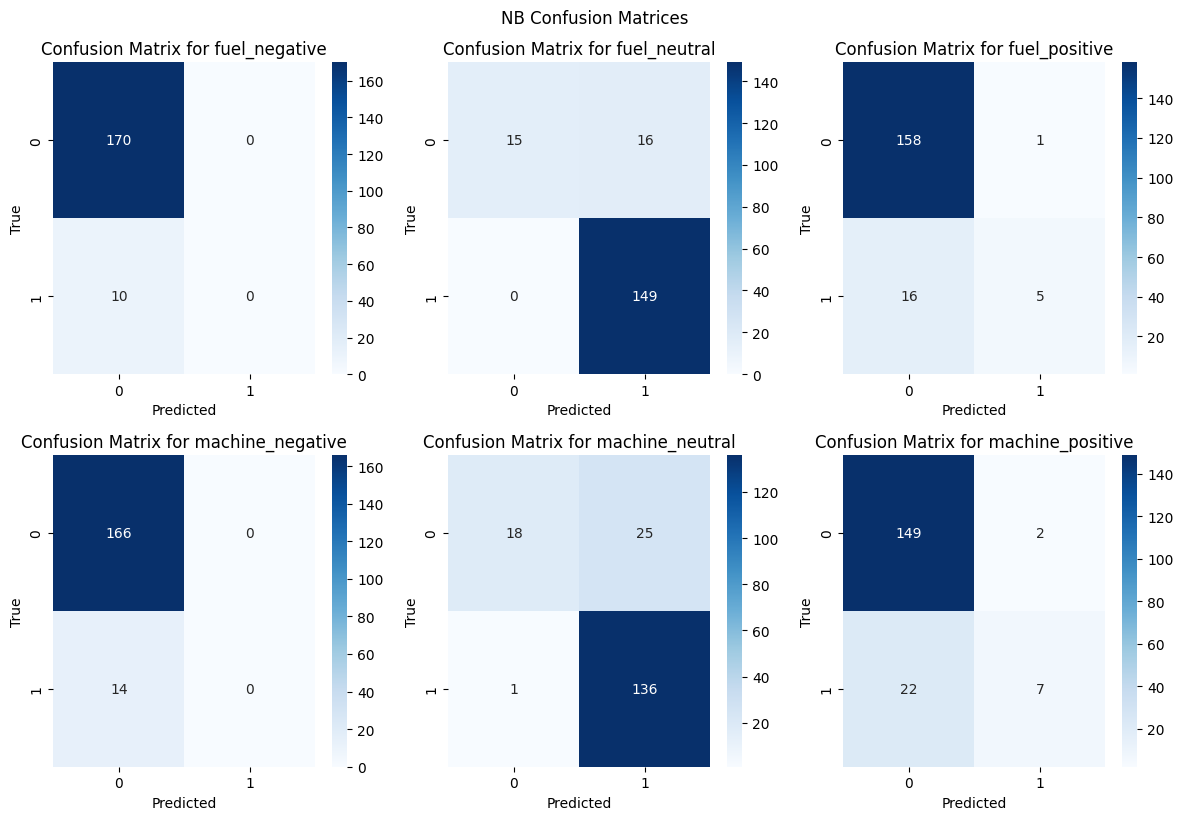


Hasil prediksi disimpan ke 'hasil_prediksi_semua_model.csv'


In [24]:
all_model_predictions = {}

for model_name, model in best_multi_models.items():
    print(f"\n{model_name} Test Evaluation:")

    y_pred_multi = model.predict(X_test_ngram)

    y_pred_df = pd.DataFrame(y_pred_multi.toarray(), columns=label_columns)
    y_pred_df['model'] = model_name
    all_model_predictions[model_name] = y_pred_df

    accuracy = accuracy_score(y_test_multi, y_pred_multi)
    print(f"Final Accuracy: {accuracy:.4f}")

    print(f"{model_name} Classification Report:")
    print(classification_report(y_test_multi, y_pred_multi,
                                target_names=label_columns, zero_division=1))

    print(f"{model_name} Confusion Matrix:")
    mcm = multilabel_confusion_matrix(y_test_multi, y_pred_multi)

    rows, cols = 2, 3
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
    axes = axes.flatten()

    for i, (ax, label) in enumerate(zip(axes, label_columns)):
        sns.heatmap(mcm[i], annot=True, fmt="d", cmap="Blues", ax=ax)
        ax.set_title(f"Confusion Matrix for {label}")
        ax.set_xlabel("Predicted")
        ax.set_ylabel("True")

    for j in range(len(label_columns), rows * cols):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.suptitle(f"{model_name} Confusion Matrices", y=1.02)
    plt.show()

combined_predictions = pd.concat(all_model_predictions.values(), ignore_index=True)
combined_predictions.to_csv("hasil_prediksi_semua_model.csv", index=False)
print("\nHasil prediksi disimpan ke 'hasil_prediksi_semua_model.csv'")